In [1]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time
from collections import OrderedDict
import optuna
import os
import joblib


sys.path.append("../")
from proj_mod import training, data_processing, visualization, param_optim, io_utils, model_io
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);
importlib.reload(param_optim);
importlib.reload(io_utils);
importlib.reload(model_io);

device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

/home/machine2/.deeplearningcourse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device cuda


In [2]:
# Dataset creation
list_time=np.load("../processed_data/recovered_time_id_order.npy")
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)

with io_utils.suppress_output():
    time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True);
    train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]
    
    train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)
    test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

In [3]:
# Model definition with parameters

def define_model_encdec(trial):

    # === Hyperparameters (Optuna) ===
    encoder_layers = trial.suggest_int("encoder_layer_num", 2, 5)
    decoder_layers = trial.suggest_int("decoder_layer_num", 2, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.4, step=0.1)   
    
    
    ts_emb_dim=32
    n_diff=2
    ts_dim=n_diff+1
    
    pos_embedder=training.pos_emb_cross_attn(length=60,
                                             ts_dim=ts_dim,
                                             emb_dim=ts_emb_dim,
                                             dropout=0.2,
                                             num_heads=4,
                                             keep_mag=True).to(device=device)
    ts_encoder_ff_layer=[
        nn.Linear(in_features=ts_emb_dim,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=ts_emb_dim)
    ]
    
    ts_decoder_ff_layer=[
        nn.Linear(in_features=ts_emb_dim,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=ts_emb_dim)
    ]
    
    output_ff=nn.Sequential(
        nn.Linear(in_features=ts_emb_dim,out_features=1)
    ).to(device=device)


    return training.encoder_decoder_teacherforcing(
        pos_emb_model=pos_embedder,
        output_feedforward=output_ff,
        encoder_dropout=dropout,
        decoder_dropout=dropout,
        encoder_feedforward_list=ts_encoder_ff_layer,
        decoder_feedforward_list=ts_decoder_ff_layer,
        n_diff=n_diff,
        encoder_layer_num=encoder_layers,
        decoder_layer_num=decoder_layers,
        input_scaler=10000,
        ts_emb_dim=ts_emb_dim,
        encoder_num_heads=4,
        decoder_num_heads=4,
        encoder_keep_mag=True,
        decoder_keep_mag=True,
        return_sum=True
    )

In [4]:
# Study creation
study_encdec = optuna.create_study(direction="minimize",
                                   pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=4)
                                  )

study_encdec.optimize(lambda trial: param_optim.objective(trial,
                                                          define_model_encdec,
                                                          train_loader,
                                                          test_loader,
                                                          device
                                                         ), n_trials=40)

[I 2025-08-08 01:56:12,649] A new study created in memory with name: no-name-88af6e0d-968d-473f-9b27-524235b48d9f
[I 2025-08-08 01:59:28,976] Trial 0 finished with value: 0.23366540670394897 and parameters: {'lr': 2.9167838844166082e-05, 'weight_decay': 0.0003560543616195853, 'encoder_layer_num': 2, 'decoder_layer_num': 2, 'dropout': 0.0}. Best is trial 0 with value: 0.23366540670394897.
[I 2025-08-08 02:05:13,231] Trial 1 finished with value: 0.23018623888492584 and parameters: {'lr': 0.00021027011561293717, 'weight_decay': 1.4468200365481732e-05, 'encoder_layer_num': 3, 'decoder_layer_num': 4, 'dropout': 0.1}. Best is trial 1 with value: 0.23018623888492584.
[I 2025-08-08 02:12:56,232] Trial 2 finished with value: 0.23256000876426697 and parameters: {'lr': 3.15003492135008e-05, 'weight_decay': 8.974867995287607e-06, 'encoder_layer_num': 5, 'decoder_layer_num': 5, 'dropout': 0.4}. Best is trial 1 with value: 0.23018623888492584.
[I 2025-08-08 02:20:39,658] Trial 3 finished with value:

In [ ]:
save_dir = "../model_data/Encoder_decoder/"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(study_encdec, os.path.join(save_dir, "checkpoint_study.pkl"))

In [14]:
# Training using optimal hyperparameters

best_trial_encdec = study_encdec.best_trial
model_encdec = define_model_encdec(optuna.trial.FixedTrial(best_trial_encdec.params)).to(device)

atts_encdec = study_encdec.best_trial.user_attrs

optimizer = torch.optim.AdamW(model_encdec.parameters(), 
                              lr=best_trial_encdec.params["lr"], 
                              weight_decay=best_trial_encdec.params["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min",
                                                       factor=atts_encdec["scheduler_factor"],
                                                       patience=atts_encdec["scheduler_patience"],
                                                       threshold=atts_encdec["threshold"],
                                                       cooldown=atts_encdec["cooldown"],
                                                       min_lr=atts_encdec["scheduler_min_lr"])

train_loss = []
val_loss = []

encdec_best_weights=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=model_encdec,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2401, device='cuda:0') .
At  19.16962766647339  epoch  1 has training loss  tensor(0.4678, device='cuda:0')  and validation loss  tensor(0.2401, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2357, device='cuda:0') .
At  98.20698308944702  epoch  5 has training loss  tensor(0.2530, device='cuda:0')  and validation loss  tensor(0.2364, device='cuda:0') .

All  5  epochs have been completed.

According to validation loss, the best model is reached at epoch 2  with validation loss:  tensor(0.2357, device='cuda:0') .

Best model state dictionary of this training loop is reloaded.

Training completed. 98.20698308944702 



In [ ]:
vis_dict={("encoder-decoder","no id"):{"train_loss": train_loss,"val_loss": val_loss}}
visualization.training_plots(vis_dict, fig_width=7, save_path=save_dir+"encdec_loss_fromtraining.png")

In [68]:
# save_dir = "../model_data/Encoder_decoder/"
# os.makedirs(save_dir, exist_ok=True)

# torch.save(model_encdec.state_dict(), os.path.join(save_dir, "encdec_best_weights.pth"))
# joblib.dump(study_encdec, os.path.join(save_dir, "encdec_study.pkl"))

model_io.save_model_and_study(
    model_encdec,
    study_encdec,
    save_dir="../model_data/Encoder_decoder",
    weights_filename="encdec_best_weights.pth",
    study_filename="encdec_study.pkl"
)

In [71]:
# save_dir = "../model_data/Encoder_decoder/"

# study_encdec = joblib.load(os.path.join(save_dir, "encdec_study.pkl"))
# best_trial_encdec = study_encdec.best_trial


# model_encdec = define_model_encdec(optuna.trial.FixedTrial(best_trial_encdec.params)).to(device)
# state = torch.load(os.path.join(save_dir, "encdec_best_weights.pth"), map_location=device)
# model_encdec.load_state_dict(state)
# with io_utils.suppress_output():
#     model_encdec.eval()

model_encdec, study_encdec = model_io.load_model_and_study(
    define_model_encdec,
    device,
    save_dir="../model_data/Encoder_decoder",
    weights_filename="encdec_best_weights.pth",
    study_filename="encdec_study.pkl"
)

In [72]:
train_loss_value = param_optim.validate(model_encdec, train_loader, device, eps=1e-8)
val_loss_value = param_optim.validate(model_encdec, test_loader, device, eps=1e-8)

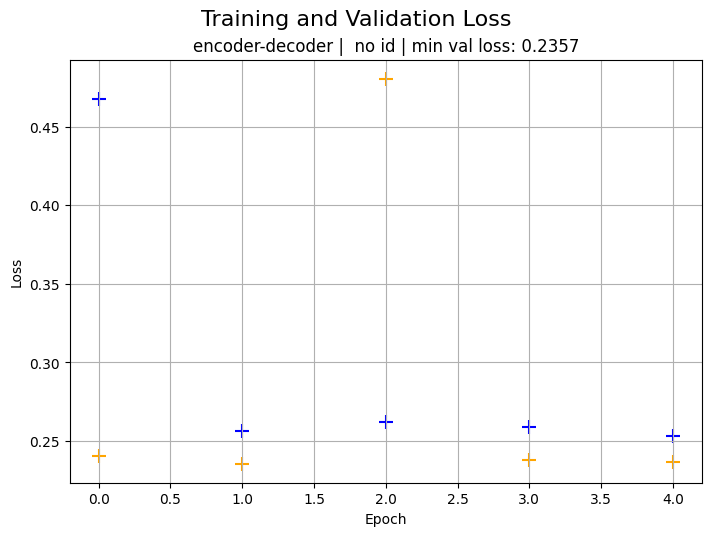

In [73]:
vis_dict={("encoder-decoder","no id"):{"train_loss": train_loss,"val_loss": val_loss}}
visualization.training_plots(vis_dict, fig_width=7, save_path=save_dir+"encdec_loss.png")